# Introduction
Existing tools help identify defect rates, document requirements and user stories, and link test cases and results to these requirements. However, they lack the capability to identify trends that explain defect rates, particularly those caused by misinterpretation of requirements or user stories by developers or testers. This is an attempt to identify trends in defect rates that can accurately determine if a defect results from such misinterpretations and understand why this occurs.

In [1]:
import json
import requests
import pandas as pd

### Define base URL for dataset and load the relevant files

In [2]:
# Define dataset base URL
BASE_URL = "https://raw.githubusercontent.com/ansymo/msr2013-bug_dataset/refs/heads/master/data/v02/eclipse/"

# Function to load JSON data from URL
def load_json(file_name):
    url = BASE_URL + file_name
    response = requests.get(url)
    if response.status_code == 200:
        return json.loads(response.text)
    else:
        print(f"Error loading {file_name}")
        return None

# Load relevant JSON files
bug_status = load_json("bug_status.json")
short_desc = load_json("short_desc.json")
severity = load_json("severity.json")
resolution = load_json("resolution.json")
component = load_json("component.json")
product = load_json("product.json")
priority = load_json("priority.json")
assigned_to = load_json("assigned_to.json")
op_sys = load_json("op_sys.json")
version = load_json("version.json")
reports = load_json("reports.json")


### Data extraction from the JSON logs

In [3]:
def extract_opened_closed_timestamps():
    """
    Extract bug opened and closed timestamps from the bug_status data
    """
    bug_data = []
    bug_status_data = bug_status["bug_status"]
    for bug_id, events in bug_status_data.items():
        if isinstance(events, list):  # Ensure events is a list
            bug_id = int(bug_id)

            # Get the earliest event (bug opened)
            opened_event = min(events, key=lambda x: x["when"])
            opened_timestamp = opened_event["when"]

            # Get the latest event where the status indicates bug closure
            closed_event = None
            for event in reversed(events):  # Start from the latest event
                if event["what"] in ["RESOLVED", "CLOSED", "VERIFIED"]:
                    closed_event = event
                    break

            closed_timestamp = closed_event["when"] if closed_event else None

            # Append extracted data
            bug_data.append({
                "bug_id": bug_id,
                "opened_timestamp": opened_timestamp,
                "closed_timestamp": closed_timestamp
            })
    return pd.DataFrame(bug_data)

def get_df(root_key, json_data, events_list):
    """
    Extract relevant data (fields) from a json file content.
    root_key: The root key of the JSON data
    json_data: The raw JSON data
    events_list: List of keys (fields) to to extract from the raw JSON data. "bug_id" is always extracted by default.

    Return a Dataframe based on the extracted fields in the JSON data
    """
    if root_key in json_data:
        root_key_data = json_data[root_key]   # Extract the nested dictionary

    data = []
    for bug_id, events in root_key_data.items():
        if "bug_status" == root_key or \
            "component" == root_key or \
            "priority" == root_key or \
            "resolution" == root_key or \
            "product" == root_key or \
            "assigned_to" == root_key or \
            "op_sys" == root_key or \
            "version" == root_key:  #Root keys with array of events
            if isinstance(events, list) and len(events) > 0:
                for event in events:
                    data_entry = {
                        "bug_id": int(bug_id)
                    }

                    if "bug_status" in events_list:
                        data_entry["bug_status"] = event.get("what")

                    if "priority" in events_list:
                        data_entry["priority"] = event.get("what")

                    if "resolution" in events_list:
                        data_entry["resolution"] = event.get("what")

                    if "timestamp" in events_list:
                        data_entry["timestamp"] = event.get("when")

                    if "component" in events_list:
                        data_entry["component"] = event.get("what")

                    if "product" in events_list:
                        data_entry["product"] = event.get("what")

                    if "assigned_to" in events_list:
                        data_entry["assigned_to"] = int(event.get("who"))
                    
                    if "op_sys" in events_list:
                        data_entry["op_sys"] = event.get("what")
                    
                    if "version" in events_list:
                        data_entry["version"] = event.get("what")

                    data.append(data_entry)
        else:
            for event in events:
                if isinstance(event, dict):  # Ensure we process only valid bug entries
                    data_entry = {
                        "bug_id": int(bug_id),
                        "timestamp": event.get("when")
                    }
                    
                    if "short_description" in events_list:
                        data_entry["short_description"] = event.get("what")

                    if "opened_timestamp" in events_list:
                        data_entry["opened_timestamp"] = event.get("opening")
                    
                    if "reporter" in events_list:
                         data_entry["reporter"] = int(event.get("reporter"))

                    if "current_status" in events_list:
                        data_entry["current_status"] = event.get("current_status")

                    if "current_resolution" in events_list:
                        data_entry["current_resolution"] = event.get("current_resolution")

                    if "severity" in events_list:
                        data_entry["severity"] = event.get("what")

                    if "resolution" in events_list:
                        data_entry["resolution"] = event.get("what")
    
                    data.append(data_entry)
    return pd.DataFrame(data)

def timestamps_to_datatime(df_data):
    """
    Convert timestamps to datetime format
    df_data: The dataframe containing multiple 'timestamp' columns
    """

    df = df_data
    for col in df.columns:
        if col.startswith("timestamp") or col.endswith("timestamp"):
            df[col] = pd.to_datetime(df[col], unit='s')
    
    return df

In [4]:
# Ensure we extract the correct level of the reports dictionary
if "reports" in reports:
    reports = reports["reports"]  # Extract the nested dictionary

# Extract Bug Opened Timestamp, Reporter, Current Status, and Resolution
bug_data = []
for bug_id, details in reports.items():
    if isinstance(details, dict):  # Ensure we process only valid bug entries
        bug_data.append({
            "bug_id": int(bug_id),
            "opened_timestamp": details.get("opening"), # Using .get() here to avoid errors if key is missing
            "reporter": int(details["reporter"]),
            "current_status": details["current_status"],
            "current_resolution": details["current_resolution"]
        })

df_reports = pd.DataFrame(bug_data)
df_reports["opened_timestamp"] = pd.to_datetime(df_reports["opened_timestamp"], unit="s")
print("df_reports")
print(df_reports.info())
print(df_reports.head())


# Extract bug status into a DataFrame
events_list = ["timestamp", "bug_status"]
df_status = get_df("bug_status", bug_status, events_list)
df_status["timestamp"] = pd.to_datetime(df_status["timestamp"], unit='s')
print("df_status")
print(df_status.info())
print(df_status.head())

# Extract short descriptions into a DataFrame
events_list = ["timestamp", "short_description"]
df_short_desc = get_df("short_desc", short_desc, events_list)
df_short_desc["timestamp"] = pd.to_datetime(df_short_desc["timestamp"], unit='s')
print("df_short_desc")
print(df_short_desc.info())
print(df_short_desc.head())

# Extract severity levels into a DataFrame
events_list = ["timestamp", "severity"]
df_severity = get_df("severity", severity, events_list)
df_severity["timestamp"] = pd.to_datetime(df_severity["timestamp"], unit='s')

# Extract Resolution
events_list = ["timestamp", "resolution"]
df_resolution = get_df("resolution", resolution, events_list)  #multiple resolutions expected
df_resolution = timestamps_to_datatime(df_resolution)
print("df_resolution")
print(df_resolution.info())
print(df_resolution.head())

# Extract Component
events_list = ["timestamp", "component"]
df_component = get_df("component", component, events_list)  #multiple components expected
df_component = timestamps_to_datatime(df_component)
print("df_component")
print(df_component.info())
print(df_component.head())

# Extract Product
events_list = ["timestamp", "product"]
df_product = get_df("product", product, events_list)  #multiple components expected
df_product = timestamps_to_datatime(df_product)

# Extract Priority Levels
events_list = ["timestamp", "priority"]
df_priority = get_df("priority", priority, events_list)
df_priority = timestamps_to_datatime(df_priority)

# Extract Assigned Developer
events_list = ["timestamp", "assigned_to"]
df_assigned_to = get_df("assigned_to", assigned_to, events_list)  #multiple assignees expected
df_assigned_to = timestamps_to_datatime(df_assigned_to)
print("df_assigned_to")
print(df_assigned_to.info())
print(df_assigned_to.head())

# Extract Operating System
events_list = ["timestamp", "op_sys"]
df_op_sys = get_df("op_sys", op_sys, events_list)
df_op_sys = timestamps_to_datatime(df_op_sys)

# Extract Software Version
events_list = ["timestamp", "version"]
df_version = get_df("version", version, events_list)
df_version = timestamps_to_datatime(df_version)

# Extract timestamps (bug opened & closed)
df_bug_opened_closed = extract_opened_closed_timestamps()
df_bug_opened_closed = timestamps_to_datatime(df_bug_opened_closed)


df_reports
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165547 entries, 0 to 165546
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   bug_id              165547 non-null  int64         
 1   opened_timestamp    165547 non-null  datetime64[ns]
 2   reporter            165547 non-null  int64         
 3   current_status      165547 non-null  object        
 4   current_resolution  165547 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 6.3+ MB
None
   bug_id    opened_timestamp  reporter current_status current_resolution
0    7524 2002-01-13 23:08:01       448       RESOLVED            WONTFIX
1    7541 2002-01-14 10:34:54       448       RESOLVED            WONTFIX
2    7544 2002-01-14 10:40:29       448         CLOSED          DUPLICATE
3    7545 2002-01-14 10:42:28       448         CLOSED              FIXED
4    7546 2002-01-14 10:46:02       

### Merge the dataframes into a Unified Dataset

In [5]:
# Check column names for all DataFrames before merging
dataframes = {
    "df_reports": df_reports,
    "df_status": df_status,
    "df_short_desc": df_short_desc,
    "df_severity": df_severity,
    "df_resolution": df_resolution,
    "df_component": df_component,
    "df_product": df_product,
    "df_priority": df_priority,
    "df_assigned_to": df_assigned_to,
    "df_op_sys": df_op_sys,
    "df_version": df_version,
    "df_bug_opened_closed": df_bug_opened_closed
}

for name, df in dataframes.items():
    print(f"{name} columns: {df.columns.tolist()}")


df_reports columns: ['bug_id', 'opened_timestamp', 'reporter', 'current_status', 'current_resolution']
df_status columns: ['bug_id', 'bug_status', 'timestamp']
df_short_desc columns: ['bug_id', 'timestamp', 'short_description']
df_severity columns: ['bug_id', 'timestamp', 'severity']
df_resolution columns: ['bug_id', 'resolution', 'timestamp']
df_component columns: ['bug_id', 'timestamp', 'component']
df_product columns: ['bug_id', 'timestamp', 'product']
df_priority columns: ['bug_id', 'priority', 'timestamp']
df_assigned_to columns: ['bug_id', 'timestamp', 'assigned_to']
df_op_sys columns: ['bug_id', 'timestamp', 'op_sys']
df_version columns: ['bug_id', 'timestamp', 'version']
df_bug_opened_closed columns: ['bug_id', 'opened_timestamp', 'closed_timestamp']


In [6]:
# Merge datasets based on bug_id and timestamp (where is it available)
no_timestamp_label_df = df_bug_opened_closed \
.merge(df_reports, on=["bug_id", "opened_timestamp"], how="outer")

df = df_short_desc \
    .merge(df_status, on=["bug_id", "timestamp"], how="outer") \
    .merge(df_severity, on=["bug_id", "timestamp"], how="outer") \
    .merge(df_resolution, on=["bug_id", "timestamp"], how="outer") \
    .merge(df_component, on=["bug_id", "timestamp"], how="outer") \
    .merge(df_product, on=["bug_id", "timestamp"], how="outer") \
    .merge(df_priority, on=["bug_id", "timestamp"], how="outer") \
    .merge(df_assigned_to, on=["bug_id", "timestamp"], how="outer") \
    .merge(df_op_sys, on=["bug_id", "timestamp"], how="outer") \
    .merge(df_version, on=["bug_id", "timestamp"], how="outer") \
    .merge(no_timestamp_label_df, on=["bug_id"], how="outer")

# Display dataframe info
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653188 entries, 0 to 653187
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   bug_id              653188 non-null  int64         
 1   timestamp           653188 non-null  datetime64[ns]
 2   short_description   226365 non-null  object        
 3   bug_status          454249 non-null  object        
 4   severity            181998 non-null  object        
 5   resolution          352352 non-null  object        
 6   component           208227 non-null  object        
 7   product             179376 non-null  object        
 8   priority            42048 non-null   object        
 9   assigned_to         330399 non-null  float64       
 10  op_sys              171884 non-null  object        
 11  version             174465 non-null  object        
 12  opened_timestamp    653188 non-null  datetime64[ns]
 13  closed_timestamp    596642 no

,bug_id,timestamp,short_description,bug_status,severity,resolution,component,product,priority,assigned_to,op_sys,version,opened_timestamp,closed_timestamp,reporter,current_status,current_resolution
0,1,2001-10-10 19:34:46,Usability issue with external editors (1GE6IRL),ASSIGNED,normal,,Team,Platform,None,21.0,All,2.0,2001-10-10 19:34:46,2006-11-09 13:17:41,21.0,CLOSED,FIXED
1,1,2001-10-19 14:36:00,NaN,RESOLVED,NaN,FIXED,NaN,NaN,NaN,NaN,NaN,NaN,2001-10-10 19:34:46,2006-11-09 13:17:41,21.0,CLOSED,FIXED
2,1,2001-10-25 08:40:50,NaN,VERIFIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-10-10 19:34:46,2006-11-09 13:17:41,21.0,CLOSED,FIXED
3,1,2006-11-09 13:17:41,NaN,CLOSED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-10-10 19:34:46,2006-11-09 13:17:41,21.0,CLOSED,FIXED
4,2,2001-10-10 19:34:47,Opening repository resources doesn't honor typ...,ASSIGNED,normal,,Team,Platform,P3,21.0,All,2.0,2001-10-10 19:34:47,2002-04-30 14:30:46,21.0,RESOLVED,FIXED


### Check Data Integrity and Handle Missing Data on Defined Sample Size

In [7]:
def show_missing_columns(dataframe):
    # Count missing values in each column
    missing_values = (dataframe.isnull() | (dataframe == "")).sum()

    # Show columns with missing values
    missing_values = missing_values[missing_values > 0]
    print(f"Columns with Missing Values:\n{missing_values}")


In [ ]:
show_missing_columns(df)
# Replace missing priorities with the most frequent priority
print("\nReplacing missing priorities with the most frequent priority...")
df["priority"].fillna(df["priority"].mode()[0], inplace=True)
show_missing_columns(df)

Columns with Missing Values:
short_description     426854
bug_status            198939
severity              471190
resolution            485224
component             444961
product               473812
priority              611140
assigned_to           322789
op_sys                481328
version               478723
closed_timestamp       56546
reporter                  12
current_status            12
current_resolution     70211
dtype: int64
Replacing missing priorities with the most frequent priority...
Columns with Missing Values:
short_description     426854
bug_status            198939
severity              471190
resolution            485224
component             444961
product               473812
assigned_to           322789
op_sys                481328
version               478723
closed_timestamp       56546
reporter                  12
current_status            12
current_resolution     70211
dtype: int64


In [29]:
bug_sample_size = 1000  #number of unique bugs in the sample
sample_bug_ids = df["bug_id"].drop_duplicates().sample(n=bug_sample_size, random_state=42)
defect_sample_df = df[df["bug_id"].isin(sample_bug_ids)]

show_missing_columns(defect_sample_df)
# Count duplicates based on bug_id and timestamp
duplicate_rows = defect_sample_df.duplicated(subset=["bug_id", "timestamp"], keep=False).sum()

# Print the number of duplicates
print(f"\n\nNumber of Duplicate Rows: {duplicate_rows}")

# Identify columns wrongly stored as float
wrong_float_columns = defect_sample_df.select_dtypes(include=["float64"]).columns.tolist()

print("Columns stored as float64 (Check if they should be int64):", wrong_float_columns)

#Replace blanks with NaN
defect_sample_df.replace("", pd.NA, inplace=True)


# Convert necessary columns to int64 after handling missing values
# for col in ["bug_id", "reporter", "assigned_to"]:
#     if col in df.columns:
#         df[col] = df[col].fillna(-1).astype("int64")  # Fill NaN before converting


#Forward-Fill Static Values Per bug_id
# Define columns where values are static per bug_id
static_cols = ["short_description", "severity", "component", "product", "version", "op_sys"]
# Apply forward-fill within each bug_id group
defect_sample_df[static_cols] = defect_sample_df.groupby("bug_id")[static_cols].ffill()

#Forward-Fill Time-Dependent Columns Per bug_id
# Define columns where missing values should be replaced with last known value
    #time_dependent_cols = ["bug_status", "assigned_to", "closed_timestamp", "priority"]
# Sort by timestamp and forward-fill within each bug_id
    #df = df.sort_values(by=["bug_id", "timestamp"])
# Apply forward-fill within each bug_id group and reset index properly
    # df[time_dependent_cols] = (
    #     df.groupby("bug_id", group_keys=False)[time_dependent_cols]
    #     .apply(lambda x: x.ffill())
    #     .infer_objects(copy=False)  # Explicitly infer object types
    # )

# Reset index to avoid any side effects from groupby operation
    #df = df.reset_index(drop=True)

# Forward-Fill & Backward-Fill Time-Dependent Columns Per bug_id
time_dependent_cols = [
    "reporter", "short_description", "bug_status", 
    "severity", "resolution", "component",
    "product", "op_sys", "version",
    "current_status", "current_resolution", "priority",
    "closed_timestamp", "assigned_to"
]
# Apply mixed backfill and forward-fill strategy
defect_sample_df = defect_sample_df.sort_values(by=["bug_id", "timestamp"])
# Apply backward-fill then forward-fill **within each bug_id group**
defect_sample_df[time_dependent_cols] = (
    defect_sample_df.groupby("bug_id", group_keys=False)[time_dependent_cols]
    .apply(lambda x: x.ffill())
    .infer_objects(copy=False)  # Explicitly infer object types
)
defect_sample_df = defect_sample_df.reset_index(drop=True)
defect_sample_df[time_dependent_cols] = (
    defect_sample_df.groupby("bug_id", group_keys=False)[time_dependent_cols]
    .apply(lambda x: x.bfill())
    .infer_objects(copy=False)  # Explicitly infer object types
)
# Reset index to avoid any side effects from groupby operation
defect_sample_df = defect_sample_df.reset_index(drop=True)

show_missing_columns(defect_sample_df)

Columns with Missing Values:
short_description     2586
bug_status            1140
severity              2832
resolution            2886
component             2687
product               2838
assigned_to           1982
op_sys                2893
version               2878
closed_timestamp       284
current_resolution     330
dtype: int64


Number of Duplicate Rows: 0
Columns stored as float64 (Check if they should be int64): ['assigned_to', 'reporter']


C:\Users\aagba\AppData\Local\Temp\ipykernel_26012\1455967661.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defect_sample_df.replace("", pd.NA, inplace=True)
C:\Users\aagba\AppData\Local\Temp\ipykernel_26012\1455967661.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defect_sample_df[static_cols] = defect_sample_df.groupby("bug_id")[static_cols].ffill()
C:\Users\aagba\AppData\Local\Temp\ipykernel_26012\1455967661.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call resul

Columns with Missing Values:
resolution            284
closed_timestamp      284
current_resolution    330
dtype: int64


In [59]:
# Remove unresolved bugs - identified by 
# Identify unresolved bugs: Missing (blank or NaN) closed_timestamp & resolution
unresolved_bugs = defect_sample_df.groupby("bug_id").filter(lambda x: x["closed_timestamp"].isna().all() and x["resolution"].isna().all())

# Remove unresolved bugs from df
filtered_df = defect_sample_df[~defect_sample_df["bug_id"].isin(unresolved_bugs["bug_id"])].copy()

# Reset index for cleanliness
filtered_df.reset_index(drop=True, inplace=True)

# Fill any remaining missing values with a placeholder ("UNKNOWN", in this case)
#filtered_df.fillna("UNKNOWN", inplace=True)

# Replace NaN with -1 (there shouldn't be any at this point) before converting to integer
filtered_df["assigned_to"] = filtered_df["assigned_to"].fillna(-1).astype("int64")
filtered_df["reporter"] = filtered_df["reporter"].fillna(-1).astype("int64")


show_missing_columns(filtered_df)


Columns with Missing Values:
current_resolution    46
dtype: int64


### Perform Defect Lifecycle Analysis

In [60]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3643 entries, 0 to 3642
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   bug_id              3643 non-null   int64         
 1   timestamp           3643 non-null   datetime64[ns]
 2   short_description   3643 non-null   object        
 3   bug_status          3643 non-null   object        
 4   severity            3643 non-null   object        
 5   resolution          3643 non-null   object        
 6   component           3643 non-null   object        
 7   product             3643 non-null   object        
 8   priority            3643 non-null   object        
 9   assigned_to         3643 non-null   int64         
 10  op_sys              3643 non-null   object        
 11  version             3643 non-null   object        
 12  opened_timestamp    3643 non-null   datetime64[ns]
 13  closed_timestamp    3643 non-null   datetime64[n

EDA

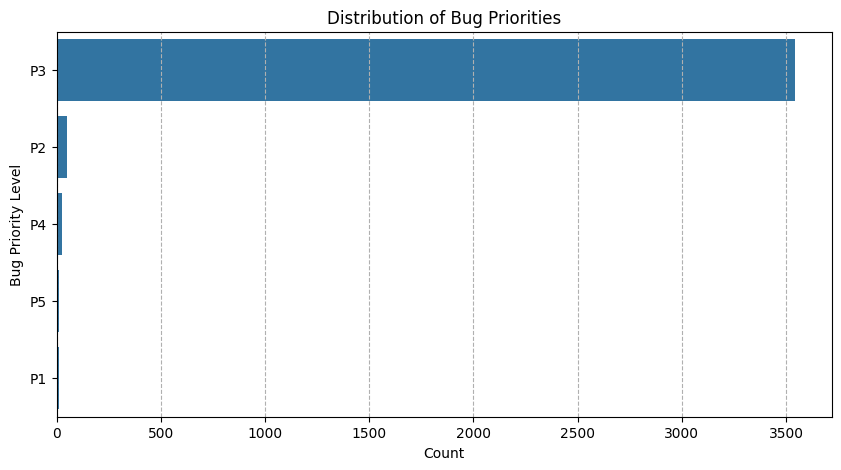

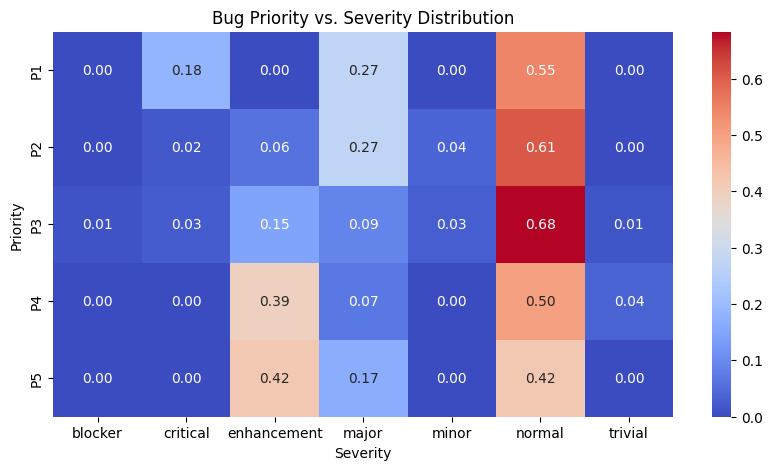

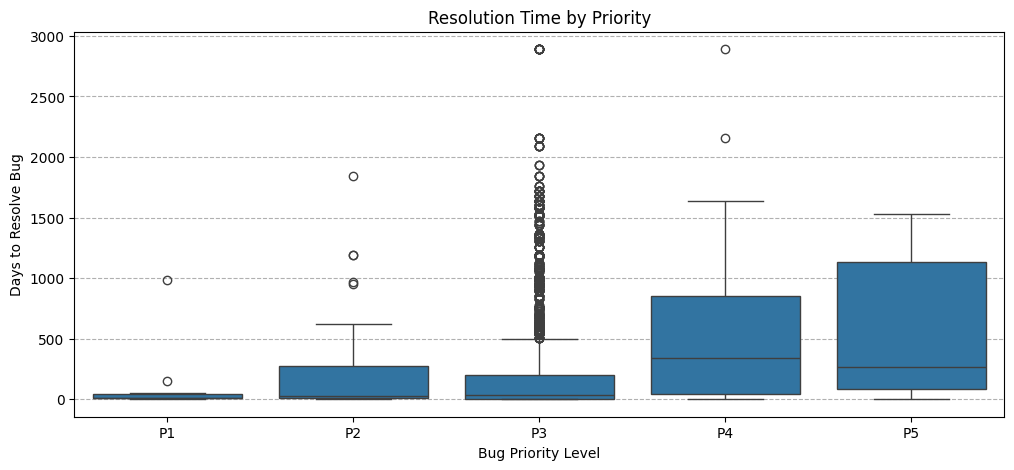

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Priority Distribution
plt.figure(figsize=(10, 5))
sns.countplot(y=filtered_df["priority"], order=filtered_df["priority"].value_counts().index)
plt.xlabel("Count")
plt.ylabel("Bug Priority Level")
plt.title("Distribution of Bug Priorities")
plt.grid(axis="x", linestyle="--")
plt.show()

# Priority vs. Severity
plt.figure(figsize=(10, 5))
sns.heatmap(pd.crosstab(filtered_df["priority"], filtered_df["severity"], normalize="index"), annot=True, cmap="coolwarm", fmt=".2f")
plt.xlabel("Severity")
plt.ylabel("Priority")
plt.title("Bug Priority vs. Severity Distribution")
plt.show()

# Priority vs. Resolution Time
filtered_df["resolution_time_days"] = (filtered_df["closed_timestamp"] - filtered_df["opened_timestamp"]).dt.days

plt.figure(figsize=(12, 5))
sns.boxplot(x="priority", y="resolution_time_days", data=filtered_df, order=sorted(filtered_df["priority"].unique()))
plt.xlabel("Bug Priority Level")
plt.ylabel("Days to Resolve Bug")
plt.title("Resolution Time by Priority")
plt.grid(axis="y", linestyle="--")
plt.show()


### Feature Engineering

In [62]:
# Feature Engineering

# 1️⃣ **Encoding Priority Levels**
priority_mapping = {"P1": 5, "P2": 4, "P3": 3, "P4": 2, "P5": 1}
filtered_df["priority_encoded"] = filtered_df["priority"].map(priority_mapping)

# 2️⃣ **Encoding Severity Levels**
severity_mapping = {
    "blocker": 5, "critical": 4, "major": 3, "normal": 2, "minor": 1, "trivial": 0
}
filtered_df["severity_encoded"] = filtered_df["severity"].map(severity_mapping)

# 3️⃣ **Encoding Bug Status**
status_mapping = {
    "NEW": 0, "ASSIGNED": 1, "RESOLVED": 2, "VERIFIED": 3, "CLOSED": 4
}
filtered_df["status_encoded"] = filtered_df["bug_status"].map(status_mapping)

# 4️⃣ **Creating Time-Based Features**
filtered_df["resolution_time_days"] = (filtered_df["closed_timestamp"] - filtered_df["opened_timestamp"]).dt.days
filtered_df["time_since_reported_days"] = (pd.to_datetime("today") - filtered_df["opened_timestamp"]).dt.days

# 5️⃣ **Extracting Text-Based Features**
filtered_df["desc_length"] = filtered_df["short_description"].str.len()

# Selecting Features for ML Model
ml_features = [
    "priority_encoded", "severity_encoded", "status_encoded",
    "resolution_time_days", "time_since_reported_days", "desc_length"
]
df_ml = filtered_df[ml_features].dropna()  # Drop rows with missing values

# Display the feature-engineered dataset
print(df_ml.info())
df_ml


<class 'pandas.core.frame.DataFrame'>
Index: 2991 entries, 0 to 3642
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   priority_encoded          2991 non-null   int64  
 1   severity_encoded          2991 non-null   float64
 2   status_encoded            2991 non-null   float64
 3   resolution_time_days      2991 non-null   int64  
 4   time_since_reported_days  2991 non-null   int64  
 5   desc_length               2991 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 163.6 KB
None


,priority_encoded,severity_encoded,status_encoded,resolution_time_days,time_since_reported_days,desc_length
0,3,2.0,1.0,1,8536,43
1,3,2.0,2.0,1,8536,43
2,3,3.0,0.0,20,8536,74
3,3,3.0,0.0,20,8536,74
4,4,3.0,0.0,20,8536,74
...,...,...,...,...,...,...
3638,3,2.0,3.0,7,5064,20
3639,3,2.0,0.0,0,5050,67
3640,3,2.0,4.0,0,5050,67
3641,3,2.0,0.0,0,5044,37


### Train an AI Model to Predict Defect Severity

Train Initial Defect Severity Prediction Model
Start by predicting defect severity using a classification model based on the engineered features.

#### Model Setup
1. Target Variable: "severity_encoded" (Predicting defect severity level).
2. Features:
    - "priority_encoded" (Bug priority).
    - "status_encoded" (Bug status).
    - "resolution_time_days" (Time taken to resolve).
    - "time_since_reported_days" (Days since report creation).
    - "desc_length" (Length of the defect description).
3. Models Used:
    - Random Forest Classifier (Baseline Model).
    - XGBoost Classifier (For performance tuning).
    - Bayesian Optimisation for hyperparameter tuning.


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define features and target variable
X = df_ml.drop(columns=["severity_encoded"])
y = df_ml["severity_encoded"]

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier as a baseline model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
classification_results = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Display classification report
df_classification_report = pd.DataFrame(classification_results).transpose()
# Display accuracy
print(f"accuracy: {accuracy}")
print("\nClassification Report (Random Forest)")

df_classification_report

accuracy: 0.9015025041736227

Classification Report (Random Forest)


,precision,recall,f1-score,support
0.0,0.900000,0.900000,0.900000,10.000000
1.0,0.750000,0.315789,0.444444,19.000000
2.0,0.914230,0.981172,0.946519,478.000000
3.0,0.877551,0.651515,0.747826,66.000000
4.0,0.571429,0.470588,0.516129,17.000000
5.0,1.000000,0.555556,0.714286,9.000000
accuracy,0.901503,0.901503,0.901503,0.901503
macro avg,0.835535,0.645770,0.711534,599.000000
weighted avg,0.896302,0.901503,0.892220,599.000000


Initial Model Performance
- Random Forest Classifier achieved 90.15% accuracy in predicting defect severity.
- Detailed classification metrics (precision, recall, F1-score) are available in the report.

#### Hyperparameter Optimisation

1. Use Bayesian Optimisation to find the best values for:
- n_estimators
- min_samples_leaf
- max_features
2. Compare the optimised model vs. the baseline.

In [64]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

# Define hyperparameter search space
param_space = {
    "n_estimators": Integer(50, 300),  # Number of trees
    "min_samples_leaf": Integer(1, 20),  # Minimum samples per leaf
    "max_features": Categorical(["sqrt", "log2", None])  # Feature selection method
}

# Define Bayesian Optimisation
bayes_search = BayesSearchCV(
    RandomForestClassifier(random_state=42),  # Base model
    param_space,
    n_iter=20,  # Number of search iterations
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    random_state=42
)

# Run Bayesian Optimisation
bayes_search.fit(X_train, y_train)

# Get the best parameters
best_params = bayes_search.best_params_

# Train the optimised model
rf_optimised = RandomForestClassifier(**best_params, random_state=42)
rf_optimised.fit(X_train, y_train)

# Predictions with optimised model
y_pred_optimised = rf_optimised.predict(X_test)

# Evaluate the optimised model
classification_results_optimised = classification_report(y_test, y_pred_optimised, output_dict=True)
accuracy_optimised = accuracy_score(y_test, y_pred_optimised)

# Display the best hyperparameters
print(f"best_params: {best_params}\naccuracy_optimised: {accuracy_optimised}")

# Display classification report
df_classification_report_optimized = pd.DataFrame(classification_results_optimised).transpose()
print("Optimised Classfication Report (Bayesian Tuned)")
df_classification_report_optimized


best_params: OrderedDict({'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 299})
accuracy_optimised: 0.9499165275459098
Optimised Classfication Report (Bayesian Tuned)


,precision,recall,f1-score,support
0.0,0.833333,1.000000,0.909091,10.000000
1.0,0.882353,0.789474,0.833333,19.000000
2.0,0.968944,0.979079,0.973985,478.000000
3.0,0.887097,0.833333,0.859375,66.000000
4.0,0.777778,0.823529,0.800000,17.000000
5.0,1.000000,0.777778,0.875000,9.000000
accuracy,0.949917,0.949917,0.949917,0.949917
macro avg,0.891584,0.867199,0.875131,599.000000
weighted avg,0.949956,0.949917,0.949387,599.000000


The Bayesian Optimised Random Forest Classifier has achieved an accuracy of 94.99%, which is a strong improvement over the initial model.

Key Observations from the Optimised Model
1. High Precision & Recall for Most Classes
- Severity Class 2.0 (major bugs) has the highest support and strong metrics.
- Class 5.0 (blocker bugs) has 100% precision but lower recall (77.8%), meaning it's good at identifying blocker bugs but may miss some.

2. Macro & Weighted Averages
- Macro Avg (0.89): Indicates some imbalance in precision-recall across classes.
- Weighted Avg (0.95): Shows the model's overall performance is very strong.

### Root Cause Analysis via Explainable AI (XAI)
Leveraging SHAP (SHapley Additive Explanations)


#### Explainability using SHAP (SHapley Additive Explanations)
Now that we have a well-tuned Random Forest Classifier, we can use SHAP to:
1. Identify which features impact defect severity most.
2. Understand how priority, status, resolution time, and other factors contribute to predictions.
3. Provide interpretable insights that can be used to optimise defect management processes.

SHAP Implementation Plan
1. Compute SHAP values for the trained model.
2. Generate feature importance plots.
3. Show how different features influence individual predictions.

100%|===================| 3591/3594 [02:18<00:00]        

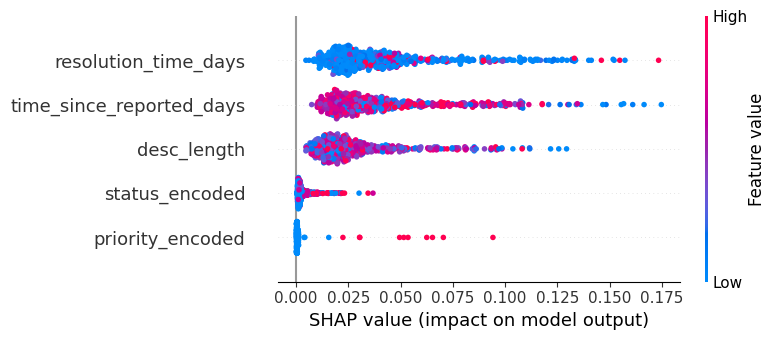

In [65]:
import shap
import numpy as np

# Initialise SHAP explainer
explainer = shap.Explainer(rf_optimised, X_train)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Convert SHAP Explanation object to NumPy array
shap_values_array = np.array(shap_values.values)  # Extract raw values

# Aggregate SHAP values by taking the mean across the third axis (multi-class outputs)
shap_values_mean = np.mean(np.abs(shap_values_array), axis=2)

# Generate SHAP summary plot with corrected input shape
shap.summary_plot(shap_values_mean, X_test, feature_names=X_test.columns)

Key Takeaways from the SHAP Results
1. Most Important Features:
- resolution_time_days (Top Feature)
  - The longer it takes to resolve a bug, the higher its predicted severity.
- time_since_reported_days
  - Older bugs seem to have a larger impact on severity classification.
- desc_length
  - The length of the bug description influences severity — longer descriptions might indicate complex or critical defects.
- status_encoded & priority_encoded
  - Bug status and priority still play a role but contribute less compared to time-related features.


###  Advanced Anomaly Detection (Isolation Forest / Autoencoder)

1. Train an Isolation Forest to detect unusual defect patterns.
2. Identify misinterpretation-based defects as outliers.
3. Compare results with your existing clustering approach.

I will attempt to:
- Fit an Isolation Forest model on the dataset.
- Assign anomaly scores to each defect.
- Visualise the distribution of anomalies.

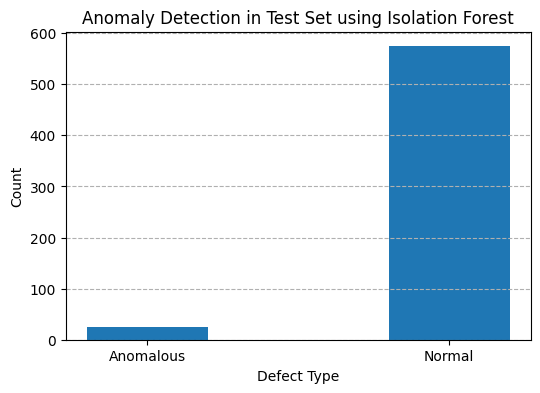

Anomalous Defects in Test Set


,priority_encoded,status_encoded,resolution_time_days,time_since_reported_days,desc_length,anomaly_score
467,5,0.0,11,8311,65,-1
100,3,0.0,2890,8535,51,-1
739,3,4.0,1842,8097,36,-1
2371,3,4.0,1347,7014,31,-1
1283,3,2.0,1605,7714,58,-1
235,3,4.0,1188,8416,28,-1
3556,3,3.0,20,5297,119,-1
3597,3,1.0,3,5210,110,-1
965,3,4.0,760,7988,34,-1
948,3,4.0,580,7990,32,-1


In [66]:
# Train Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

# Train Isolation Forest on training data
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X_train)

# Predict anomalies on test data
X_test["anomaly_score"] = iso_forest.predict(X_test)

# Count normal vs anomalous defects
anomaly_counts = X_test["anomaly_score"].value_counts()

# Plot anomaly distribution in test set
plt.figure(figsize=(6, 4))
plt.bar(anomaly_counts.index, anomaly_counts.values, tick_label=["Normal", "Anomalous"])
plt.xlabel("Defect Type")
plt.ylabel("Count")
plt.title("Anomaly Detection in Test Set using Isolation Forest")
plt.grid(axis="y", linestyle="--")
plt.show()

# Extract and display detected anomalies from X_test
df_anomalies_test = X_test[X_test["anomaly_score"] == -1]
print("Anomalous Defects in Test Set")
df_anomalies_test

### Feature Importance Using RandomForest
- Use NLP (TF-IDF or Embeddings) to transform text descriptions into features.
- Apply SHAP to identify the most influential words/phrases for defect severity.
- Generate WordClouds & Bar Charts showing the most impactful terms.

100%|===================| 17928/17946 [08:23<00:00]        

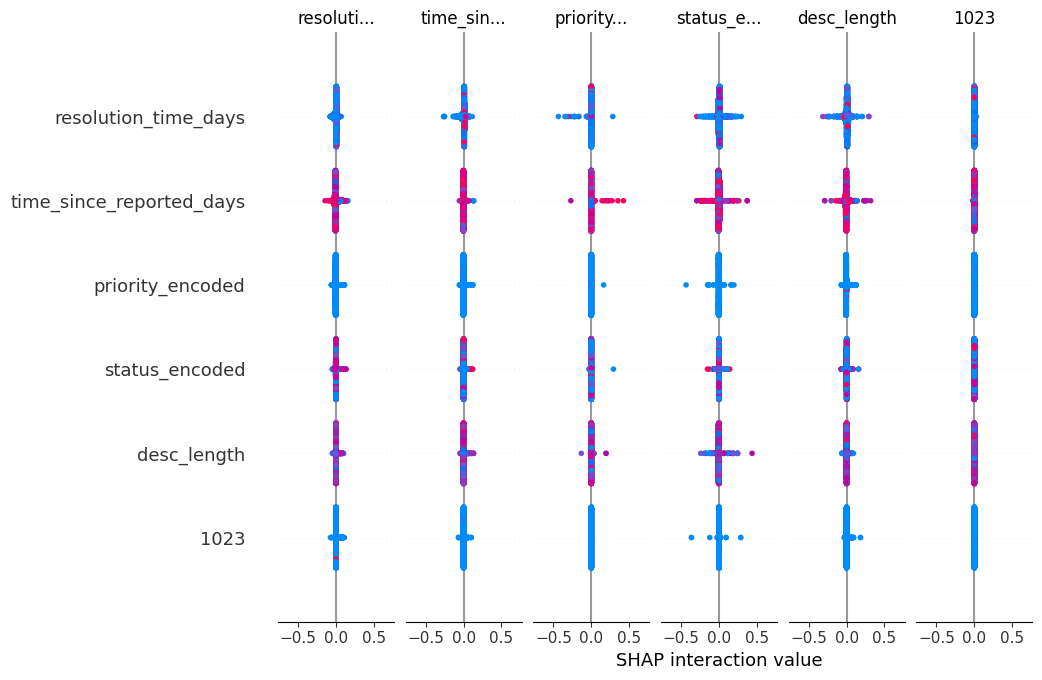

C:\Users\aagba\AppData\Local\Temp\ipykernel_26012\2151128148.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")


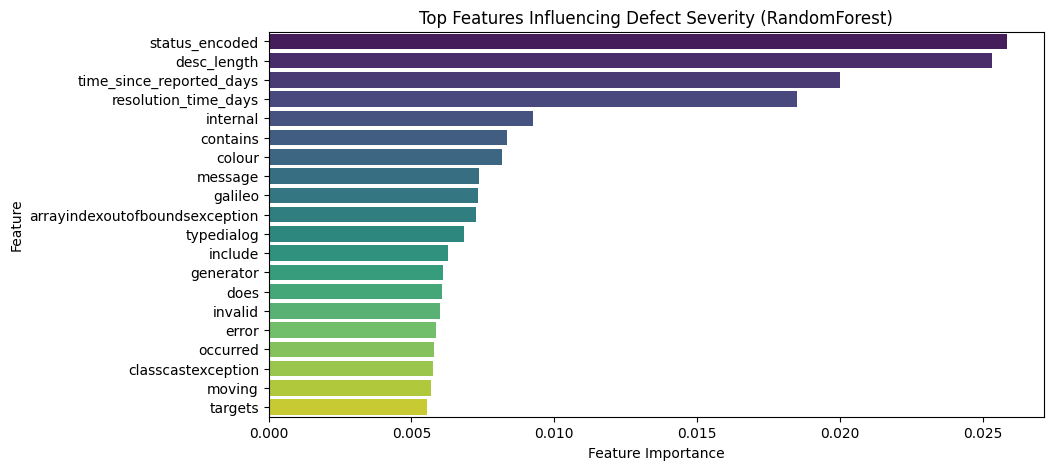

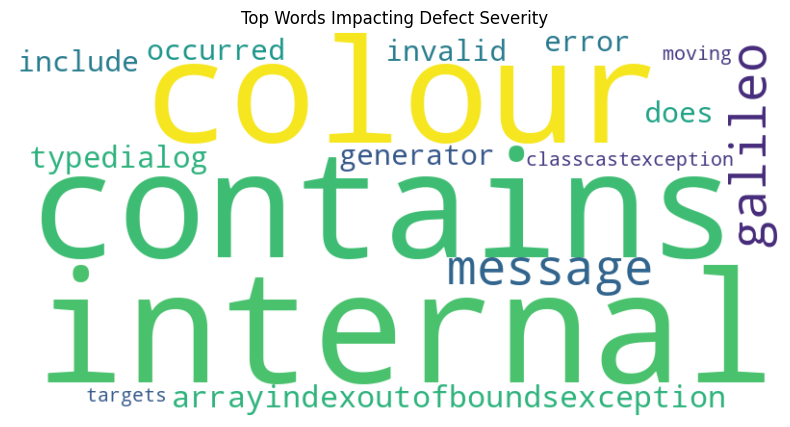

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer



#---------------
# Select ML features along with text
ml_features_nlp = ml_features + ["short_description"]

# Extract relevant features and drop rows with missing values
df_ml_nlp = filtered_df[ml_features_nlp].dropna()

# Define structured features and target variable
X_structured = df_ml_nlp.drop(columns=["severity_encoded", "short_description"])
y_nlp = df_ml_nlp["severity_encoded"]

# Vectorize defect descriptions using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X_text = vectorizer.fit_transform(df_ml_nlp["short_description"].astype(str))

# Convert TF-IDF output to DataFrame and merge with structured features
X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())
X_combined_nlp = pd.concat([X_structured.reset_index(drop=True), X_text_df], axis=1)

# Train a RandomForest model for SHAP analysis
rf_model_nlp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_nlp.fit(X_combined_nlp, y_nlp)

# Explain model predictions using SHAP
explainer_nlp = shap.Explainer(rf_model_nlp, X_combined_nlp)
shap_values_nlp = explainer_nlp(X_combined_nlp)

# Display SHAP summary plot for text features
shap.summary_plot(shap_values_nlp, X_combined_nlp, feature_names=X_combined_nlp.columns)

#----------------

# Get feature importance from the trained RandomForest model
feature_importance = rf_model_nlp.feature_importances_

# Create a DataFrame to sort and display top features
feature_names = X_combined_nlp.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(20)

# Plot top features using a bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top Features Influencing Defect Severity (RandomForest)")
plt.show()

# Generate a WordCloud for top text features
top_words = feature_importance_df[feature_importance_df["Feature"].isin(vectorizer.get_feature_names_out())]

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(
    dict(zip(top_words["Feature"], top_words["Importance"]))
)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top Words Impacting Defect Severity")
plt.show()


Key Insights
1. Top Structured Features Impacting Defect Severity:
    - resolution_time_days: The longer a defect takes to resolve, the more severe it tends to be.
    - bug_status_encoded: The defect's status influences its severity.
    - desc_length: Longer descriptions may indicate more complex or severe defects.
    - time_since_reported_days: Older defects may correlate with severity.
2. Top Words Impacting Defect Severity (From TF-IDF Analysis):
    - "contains", "internal", "colour", "message", "galileo
    - These words likely appear in high-severity defects, indicating potential requirement misunderstandings.

### Putting it all together in an End-to-End ML Pipeline

#### Define a function to build the ML pipeline

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

def build_defect_analysis_pipeline(df):
    """
    Constructs an end-to-end ML pipeline for defect severity classification and anomaly detection.
    """

    # 1 - Feature Engineering
    # Encode categorical features
    categorical_features = ["priority", "bug_status", "severity"]
    label_encoders = {}

    for col in categorical_features:
        le = LabelEncoder()
        df[f"{col}_encoded"] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le  # Store encoder for reference

    # Create time-based features
    df["resolution_time_days"] = (df["closed_timestamp"] - df["opened_timestamp"]).dt.days.fillna(-1)
    df["time_since_reported_days"] = (pd.Timestamp.now() - df["opened_timestamp"]).dt.days

    # Compute description length
    df["desc_length"] = df["short_description"].astype(str).apply(len)

    # Select ML features along with text
    ml_features_nlp = [
        "priority_encoded", "severity_encoded", "bug_status_encoded",
        "resolution_time_days", "time_since_reported_days", "desc_length", "short_description"
    ]

    # Extract relevant features and drop rows with missing values
    df_ml = df[ml_features_nlp].dropna()

    # 2 - Define Features & Target
    X_structured = df_ml.drop(columns=["severity_encoded", "short_description"])
    y = df_ml["severity_encoded"]

    # Vectorise defect descriptions using TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
    X_text = vectorizer.fit_transform(df_ml["short_description"].astype(str))

    # Convert TF-IDF output to DataFrame and merge with structured features
    X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())
    X_combined = pd.concat([X_structured.reset_index(drop=True), X_text_df], axis=1)

    # Split dataset into training (80%) and testing (20%)
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y, test_size=0.2, random_state=42, stratify=y
    )

    # 3 - Define ML Pipeline Components
    pipeline = Pipeline([
        ("scaler", StandardScaler()),  # Standardize numerical features
        ("classifier", RandomForestClassifier(n_estimators=200, min_samples_leaf=2, max_features="sqrt", random_state=42))
    ])

    # Train Model
    pipeline.fit(X_train, y_train)

    # 4 - Anomaly Detection (Isolation Forest)
    iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    iso_forest.fit(X_train)
    X_test["anomaly_score"] = iso_forest.predict(X_test)

    # 5 - Feature Importance Analysis
    feature_importance = pipeline.named_steps["classifier"].feature_importances_
    feature_names = X_combined.columns
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance}).sort_values(by="Importance", ascending=False)

    return pipeline, iso_forest, feature_importance_df, X_test


def handle_missing_data(dataset):
	"""
	Handle miising data in the specified data
	dataset: The defect dataset
	Returns sanitised dataset with no missing values.
	"""
	#show_missing_columns(dataset)
	# Count duplicates based on bug_id and timestamp
	duplicate_rows = dataset.duplicated(subset=["bug_id", "timestamp"], keep=False).sum()

	# Print the number of duplicates
	print(f"\n\nNumber of Duplicate Rows: {duplicate_rows}")

	# Identify columns wrongly stored as float
	wrong_float_columns = dataset.select_dtypes(include=["float64"]).columns.tolist()

	print("Columns stored as float64 (Check if they should be int64):", wrong_float_columns)

	#Replace blanks with NaN
	dataset.replace("", pd.NA, inplace=True)

	#Forward-Fill Static Values Per bug_id
	# Define columns where values are static per bug_id
	static_cols = ["short_description", "severity", "component", "product", "version", "op_sys"]
	# Apply forward-fill within each bug_id group
	dataset[static_cols] = dataset.groupby("bug_id")[static_cols].ffill()

	# Forward-Fill & Backward-Fill Time-Dependent Columns Per bug_id
	time_dependent_cols = [
		"reporter", "short_description", "bug_status", 
		"severity", "resolution", "component",
		"product", "op_sys", "version",
		"current_status", "current_resolution", "priority",
		"closed_timestamp", "assigned_to"
	]
	# Apply mixed backfill and forward-fill strategy
	dataset = dataset.sort_values(by=["bug_id", "timestamp"])
	# Apply backward-fill then forward-fill **within each bug_id group**
	dataset[time_dependent_cols] = (
		dataset.groupby("bug_id", group_keys=False)[time_dependent_cols]
		.apply(lambda x: x.ffill())
		.infer_objects(copy=False)  # Explicitly infer object types
	)
	dataset = dataset.reset_index(drop=True)
	dataset[time_dependent_cols] = (
		dataset.groupby("bug_id", group_keys=False)[time_dependent_cols]
		.apply(lambda x: x.bfill())
		.infer_objects(copy=False)  # Explicitly infer object types
	)
	# Reset index to avoid any side effects from groupby operation
	dataset = dataset.reset_index(drop=True)

	#show_missing_columns(dataset)

	# Remove unresolved bugs - identified by 
	# Identify unresolved bugs: Missing (blank or NaN) closed_timestamp & resolution
	unresolved_bugs = dataset.groupby("bug_id").filter(lambda x: x["closed_timestamp"].isna().all() and x["resolution"].isna().all())

	# Remove unresolved bugs from df
	filtered_dataset = dataset[~dataset["bug_id"].isin(unresolved_bugs["bug_id"])].copy()

	# Reset index for cleanliness
	filtered_dataset.reset_index(drop=True, inplace=True)

	# Replace NaN with -1 (there shouldn't be any at this point) before converting to integer
	filtered_dataset["assigned_to"] = filtered_dataset["assigned_to"].fillna(-1).astype("int64")
	filtered_dataset["reporter"] = filtered_dataset["reporter"].fillna(-1).astype("int64")

	#show_missing_columns(filtered_dataset)


	return filtered_dataset


### Run the Pipeline

In [ ]:
pip install ace-tools-open

In [ ]:
use_full_dataset = False   #Set this to True to run the pipeline on the entire dataset.  Set to False to use a sample dataset due to computational time contraints

# Run the pipeline
if use_full_dataset:
    dataset_df = df.copy()
else:
    bug_sample_size = 1000  #number of unique bugs in the sample
    sample_bug_ids = df["bug_id"].drop_duplicates().sample(n=bug_sample_size, random_state=42)
    dataset_df = df[df["bug_id"].isin(sample_bug_ids)]

defect_dataset = handle_missing_data(dataset_df)
pipeline_model, anomaly_model, feature_importance_results, test_data_with_anomalies = build_defect_analysis_pipeline(defect_dataset)

# Display feature importance results
print(f"Feature Importance Results\n{feature_importance_results}")

# Display test dataset with anomaly scores
print(f"Test Data with Anomaly Scores\n{test_data_with_anomalies}")



Number of Duplicate Rows: 0
Columns stored as float64 (Check if they should be int64): ['assigned_to', 'reporter']


C:\Users\aagba\AppData\Local\Temp\ipykernel_26012\1034975011.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.replace("", pd.NA, inplace=True)
C:\Users\aagba\AppData\Local\Temp\ipykernel_26012\1034975011.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[static_cols] = dataset.groupby("bug_id")[static_cols].ffill()
C:\Users\aagba\AppData\Local\Temp\ipykernel_26012\1034975011.py:120: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False

Feature Importance Results
                      Feature  Importance
2        resolution_time_days    0.025134
4                 desc_length    0.017977
3    time_since_reported_days    0.016657
28                        add    0.012789
466                      item    0.008583
..                        ...         ...
792                       sdk    0.000000
813                  settitle    0.000000
129                  changing    0.000000
125               celleditors    0.000000
415                        id    0.000000

[1005 rows x 2 columns]
Test Data with Anomaly Scores
      priority_encoded  bug_status_encoded  resolution_time_days  \
3401                 2                   4                     2   
851                  2                   2                    35   
1854                 2                   4                     0   
646                  2                   2                     0   
263                  2                   4                  1179   
...   

(                      Feature  Importance
 2        resolution_time_days    0.025134
 4                 desc_length    0.017977
 3    time_since_reported_days    0.016657
 28                        add    0.012789
 466                      item    0.008583,
       priority_encoded  bug_status_encoded  resolution_time_days  \
 3401                 2                   4                     2   
 851                  2                   2                    35   
 1854                 2                   4                     0   
 646                  2                   2                     0   
 263                  2                   4                  1179   
 
       time_since_reported_days  desc_length  1023  1fh2fpi  1gc2ewf  1gensr6  \
 3401                      5755           50   0.0      0.0      0.0      0.0   
 851                       8033           84   0.0      0.0      0.0      0.0   
 1854                      7429           56   0.0      0.0      0.0      0.0   
 

In [79]:
feature_importance_results

,Feature,Importance
2,resolution_time_days,0.025134
4,desc_length,0.017977
3,time_since_reported_days,0.016657
28,add,0.012789
466,item,0.008583
...,...,...
792,sdk,0.000000
813,settitle,0.000000
129,changing,0.000000
125,celleditors,0.000000


In [81]:
test_data_with_anomalies

,priority_encoded,bug_status_encoded,resolution_time_days,time_since_reported_days,desc_length,1023,1fh2fpi,1gc2ewf,1gensr6,1getdt9,...,workbenchstatusdialogmanager,working,workspace,wrong,xalan,xml,xxx,yield,zip,anomaly_score
3401,2,4,2,5755,50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1
851,2,2,35,8033,84,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1
1854,2,4,0,7429,56,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.482316,0.0,0.0,0.0,0.0,1
646,2,2,0,8150,50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1
263,2,4,1179,8409,53,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2327,2,2,3,7053,59,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1
3547,2,2,16,5311,49,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1
901,2,4,45,8022,68,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1
1128,2,2,81,7835,47,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1


### Key Outputs:
1. Feature Importance Results → Displays the most impactful structured & textual features.
2. Test Data with Anomaly Scores → Shows defect cases flagged as anomalies.